In [1]:
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 0

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(8)


def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            # 'dataset': "MNIST",
            'dataset': "FashionMNIST",
            'random_class_idx': False,

            # benchmark
            'seed': seed,
            'num_tasks': 5,
            'epochs_per_task': 5,
            'per_task_examples': np.inf,
            # 'per_task_examples': 10000,
            'per_task_memory_examples': 64,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 10.,
            # 'tau': 0.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            'device': torch.device('cuda:6' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha':0.001,
            'lambda': .1,
            'lambda_old': 0.0,
              }

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_alpha={params['alpha']}_tau={params['tau']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=FashionMNIST/seed=0_epoch=5_lr=0.001_alpha=0.001_tau=10.0


In [2]:
from datasets import MNIST
from datasets import FashionMNIST

if params['dataset'] == 'MNIST':
    benchmark = MNIST(num_tasks=params['num_tasks'],
                    per_task_memory_examples=params['per_task_memory_examples'],
                    per_task_examples = params['per_task_examples'],
                    random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'FashionMNIST':
    benchmark = FashionMNIST(num_tasks=params['num_tasks'],
                            per_task_memory_examples=params['per_task_memory_examples'],
                            per_task_examples = params['per_task_examples'],
                            random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
else:
    raise NotImplementedError
class_idx = benchmark.class_idx
num_classes = len(class_idx)



[0 1 2 3 4 5 6 7 8 9]


In [3]:
from algorithms.imbalance import ImbalanceAlgorithm
from metrics import MetricCollector2
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
algorithm = ImbalanceAlgorithm(backbone, benchmark, params, requires_memory=True)
metric_manager_callback = MetricCollector2(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])

In [4]:
from trainers.imbalance_trainer import ImbalanceContinualTrainer1 as ContinualTrainer

trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.9715, 'loss': 0.00033985645696520806, 'std': 0.004500000000000004, 'EER': -1}
[2] Eval metrics for task 1 >> {'accuracy': 0.978, 'loss': 0.000244151184335351, 'std': 0.0, 'EER': -1}
[3] Eval metrics for task 1 >> {'accuracy': 0.9815, 'loss': 0.00020586758106946946, 'std': 0.006500000000000006, 'EER': -1}
[4] Eval metrics for task 1 >> {'accuracy': 0.984, 'loss': 0.0001882472177967429, 'std': 0.007000000000000006, 'EER': -1}
[5] Eval metrics for task 1 >> {'accuracy': 0.985, 'loss': 0.0001759307961910963, 'std': 0.006000000000000005, 'EER': -1}
training_task_end
---------------------------- Task 2 -----------------------
Elapsed time(grad):5.733
losses=tensor([[ 0.0198,  0.0195,  8.7685, 12.5658]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):11.283
Fairness:[ 0.          0.79366192  0.06358251 -0.8572444 ]
Current class expected loss:[ 0.          0. 

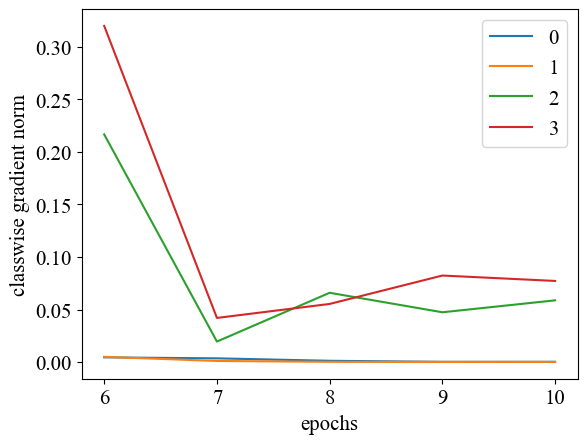

---------------------------- Task 3 -----------------------
Elapsed time(grad):6.735
losses=tensor([[6.1697e-04, 4.2972e-04, 1.0220e+00, 6.6581e-01, 1.0766e+01, 5.0212e+00]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):14.722
Fairness:[ 0.33580073  0.34593127 -0.10027229  0.04606414 -0.62752403  0.        ]
Current class expected loss:[ 0.          0.          0.          0.         -0.26665879 -0.07840162]
len(updated_seq_indices)=9024
[11] Eval metrics for task 1 >> {'accuracy': 0.8545, 'loss': 0.0026130593866109846, 'std': 0.0645, 'EER': -1}
[11] Eval metrics for task 2 >> {'accuracy': 0.76, 'loss': 0.0031204813420772554, 'std': 0.039000000000000035, 'EER': -1}
[11] Eval metrics for task 3 >> {'accuracy': 0.9139999999999999, 'loss': 0.0010427628234028817, 'std': 0.07700000000000001, 'EER': -1}
Elapsed time(grad):5.502
losses=tensor([[0.0048, 0.0044, 0.0438, 0.0227, 0.3994, 0.1416]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(

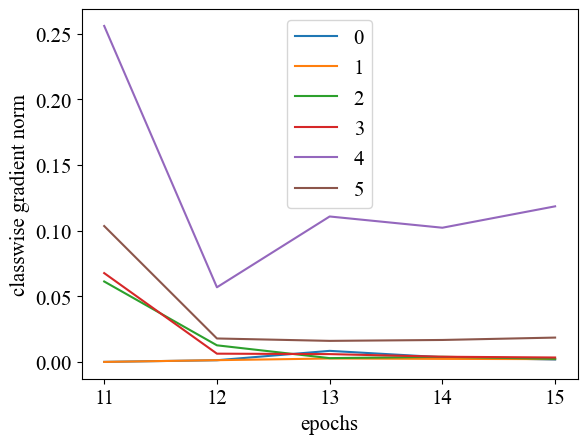

---------------------------- Task 4 -----------------------
Elapsed time(grad):5.059
losses=tensor([[9.2899e-03, 4.1465e-03, 8.8448e-03, 9.5310e-03, 7.3148e-01, 7.8498e-02,
         1.1693e+01, 8.8563e+00]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):18.649
Fairness:[ 0.17198677  0.2227017   0.20766674  0.28182848  0.05449505 -0.09969759
 -0.66834691 -0.17063428]
Current class expected loss:[ 0.          0.          0.          0.          0.          0.
 -0.34138961 -0.14230459]
len(updated_seq_indices)=12000
[16] Eval metrics for task 1 >> {'accuracy': 0.7484999999999999, 'loss': 0.004442325592041016, 'std': 0.16950000000000004, 'EER': -1}
[16] Eval metrics for task 2 >> {'accuracy': 0.614, 'loss': 0.006746992468833923, 'std': 0.129, 'EER': -1}
[16] Eval metrics for task 3 >> {'accuracy': 0.7130000000000001, 'loss': 0.0032867903709411623, 'std': 0.04799999999999999, 'EER': -1}
[16] Eval metrics for task 4 >> {'accuracy': 0.8200000000000001, 'loss': 0.

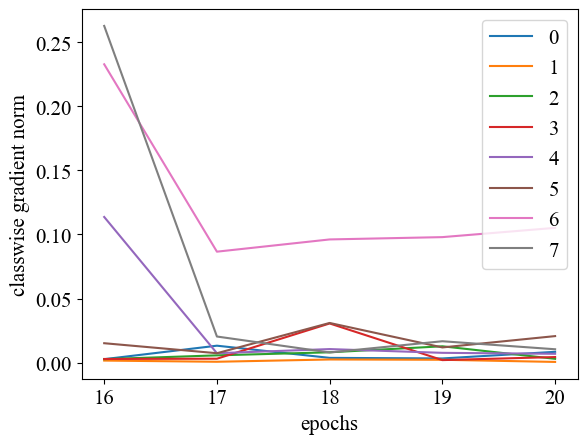

---------------------------- Task 5 -----------------------
Elapsed time(grad):6.628
losses=tensor([[8.7837e-03, 5.5662e-03, 1.2797e-02, 6.6567e-02, 2.0752e-02, 4.6943e-02,
         1.2180e+00, 1.3534e-01, 8.1631e+00, 1.0387e+01]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):22.747
Fairness:[ 0.14577574  0.11983806  0.16066068  0.14986013  0.09223527  0.210518
 -0.12869993 -0.12563444 -0.25013431 -0.37441947]
Current class expected loss:[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.16152417 -0.22366673]
len(updated_seq_indices)=11264
[21] Eval metrics for task 1 >> {'accuracy': 0.768, 'loss': 0.005037185102701187, 'std': 0.14600000000000002, 'EER': -1}
[21] Eval metrics for task 2 >> {'accuracy': 0.6225, 'loss': 0.008337077021598817, 'std': 0.1355, 'EER': -1}
[21] Eval metrics for task 3 >> {'accuracy': 0.622, 'loss': 0.006127363979816437, 'std': 0.04600000000000004, 'EER': -1}
[21] Eval metrics for task 4 >

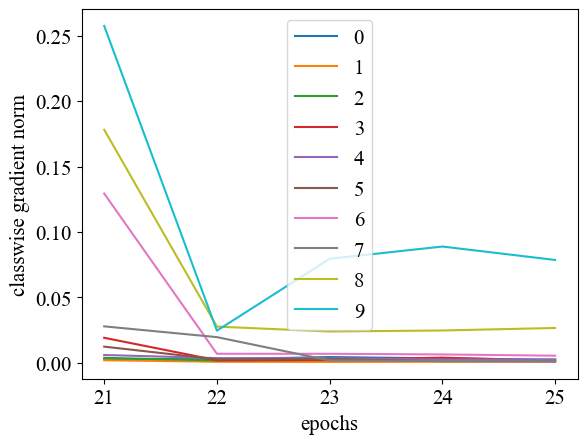

final avg-acc 0.7363999999999999
final avg-forget 0.16225


In [5]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [7]:
metric_manager_callback.meters['accuracy'].get_data()

array([[0.985, 0.   , 0.   , 0.   , 0.   ],
       [0.941, 0.774, 0.   , 0.   , 0.   ],
       [0.824, 0.82 , 0.847, 0.   , 0.   ],
       [0.794, 0.563, 0.693, 0.794, 0.   ],
       [0.772, 0.608, 0.624, 0.827, 0.851]])

In [8]:
np.mean(metric_manager_callback.meters['accuracy'].compute_overall())

0.8240383333333332

In [9]:
[np.round(x, 3) for x in metric_manager_callback.meters['EER'].compute_overall()]

[0.0, 0.084, 0.011, 0.083, 0.097]

In [10]:
np.mean(metric_manager_callback.meters['EER'].compute_overall())

0.054846777777777765

In [11]:
[np.round(x, 3) for x in metric_manager_callback.meters['std'].compute_overall()]

[0.006, 0.085, 0.098, 0.148, 0.153]

In [12]:
np.mean(metric_manager_callback.meters['std'].compute_overall())

0.09813281356742032

In [13]:
print(f"accuracy:{np.mean(metric_manager_callback.meters['accuracy'].compute_overall())}")
print(f"EER:{np.mean(metric_manager_callback.meters['EER'].compute_overall())}")
print(f"std:{np.mean(metric_manager_callback.meters['std'].compute_overall())}")


accuracy:0.8240383333333332
EER:0.054846777777777765
std:0.09813281356742032
